<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [0]:
!pip install --pre --quiet astroquery

In [76]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0


## Datos del SDSS

Disponible en enlace



###Consulta con Astroquery###

In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 10000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z, s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class = 'STAR'
                      
                      """)

In [169]:
datapd=data.to_pandas()
datapd = datapd[(datapd != -9999).dropna()]
datapd = datapd.dropna()
print(datapd)

      fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0       19.29164    18.18115    17.81282    17.69375    17.66903        5373
1       21.83404    19.30373    17.88528    16.98804    16.41673        3980
2       19.36734    18.48736    18.15342    18.01115    17.91279        6000
3       19.42088    17.92244    17.13913    16.93484    16.73513        5000
4       19.15921    19.11771    19.36260    19.59598    19.76112        7652
5       19.00502    17.71554    17.19506    17.02796    16.96775        5762
6       19.45036    18.02126    17.41052    17.16474    17.03034        5320
7       19.46083    17.53469    16.71348    16.38574    16.17171        4955
8       18.73582    17.19462    16.49559    16.21076    16.02629        5139
9       19.69338    17.83335    17.14591    16.89997    16.77325        5139
10      20.01330    20.41864    20.88561    21.17669    21.03999        9656
11      20.25025    17.65621    16.25324    15.62062    15.19448        3890

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)

### Chequeo a los datos

Estadísticas:

In [171]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,7998.0,20.625057,2.211412,14.07160,18.994655,20.215620,22.108740,26.51366
fiberMag_g,7998.0,19.264443,1.987911,13.48535,17.841330,18.933590,20.418067,26.15056
fiberMag_r,7998.0,18.621684,1.679406,12.84478,17.369120,18.387265,19.841085,23.62120
fiberMag_i,7998.0,18.183207,1.433061,13.57713,17.068323,18.099895,19.327753,24.05245
fiberMag_z,7998.0,17.948185,1.445990,12.63962,16.895453,17.846035,18.886120,25.42421


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [0]:
norm_train_labels = norm(train_labels)
norm_train_feat = norm(train_feat)

norm_test_feat = norm(test_feat)

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

###Estructura de la red neuronal

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(5, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    layers.Dense(1, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

###Desnormalización

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo

### Inspección del modelo

In [177]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 6         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 2         
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [178]:
# Imprime un punto por cada epoch completado
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

El progreso de entrenamiento del sistema está en el objeto `history`.

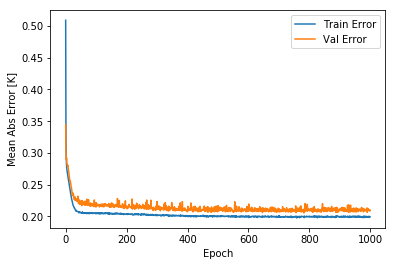

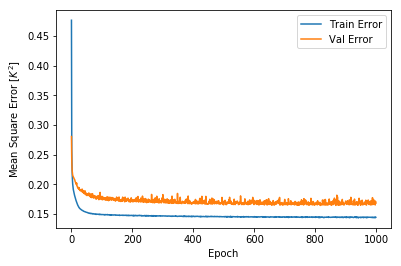

In [179]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

###Tiempo de Ejecución

In [0]:
t_fin = time()
t_ejecucion = t_fin - t_ini

### Predicción con los datos de prueba

(3195.3901433691753, 14076.609856630823, 3195.4, 14076.619713261647)

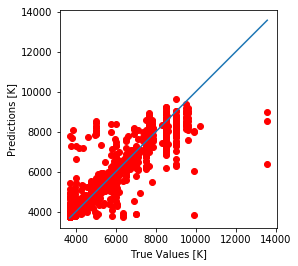

In [181]:
test_predictions = model.predict(norm_test_feat).flatten()

test_predictions = desnorm(test_predictions, train_labels.mean(), train_labels.std())
m1 = min(test_labels)
M1 = max(test_labels)

m2 = min(test_predictions)
M2 = max(test_predictions)

m = min([m1, m2])
M = max([M1, M2])

plt.scatter(test_labels, test_predictions, color='red')
plt.plot([m , M], [m, M])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

Notemos que nuestro modelo se debe acercar a la función de  identidad. Ahora veamos la distribución del error absoluto:



### Errores

Tiempo de Ejecución: 284.43244218826294
Error Absoluto Medio: 344.7810390625
Error Cuadrático Medio: 414678.50633327913


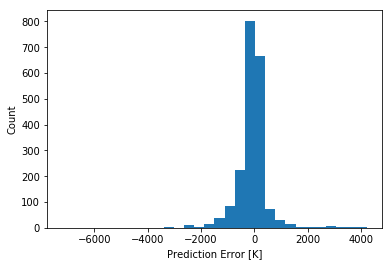

In [182]:
import numpy as np
error = test_predictions - test_labels
error2 = error**2

plt.hist(error, bins = 30)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

MeanAbsError = np.abs(error).mean()
MeanSQError = error2.mean()

print('Tiempo de Ejecución:', t_ejecucion)
print('Error Absoluto Medio:', MeanAbsError)
print('Error Cuadrático Medio:', MeanSQError)